In [172]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbr
from numpy.random import uniform
import networkx as nx

from sklearn.metrics import mean_absolute_error, mean_squared_error

from sklearn import preprocessing, model_selection
from statsmodels.api import qqplot_2samples

from scipy.stats import pearsonr, ks_2samp

sbr.set(rc={'figure.figsize':[15, 10]})
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
%matplotlib inline

dataset = pd.read_csv("/home/rami/hdd/multivariable_analysis/kc_house_data.csv")

target = 'price'
predictors = ['price', 'sqft_living', 'sqft_living15', 'sqft_above', 'sqft_basement']


dataset = dataset.drop(dataset.loc[dataset.price > 3430000.0].index)

data = dataset[ ['price', 'sqft_living', 'bedrooms', 'bathrooms', 'grade', 'condition', 'sqft_living15', 'sqft_above', 'sqft_basement'] ]
data.head()

,price,sqft_living,bedrooms,bathrooms,grade,condition,sqft_living15,sqft_above,sqft_basement
0,221900.0,1180,3,1.00,7,3,1340,1180,0
1,538000.0,2570,3,2.25,7,3,1690,2170,400
2,180000.0,770,2,1.00,6,3,2720,770,0
3,604000.0,1960,4,3.00,7,5,1360,1050,910
4,510000.0,1680,3,2.00,8,3,1800,1680,0


# Sampling

In [166]:
import scipy.interpolate as interpolate

def inverse_transform_sampling(df, n_buckets=100, n_samples=1000):
    
    its_data = dict()
    
    for label in df.columns:
    
        data = df[label]
        
        if data.unique().shape[0] < 100:
            n_bins = np.unique(data)
        else:
            n_bins = n_buckets
        
        hist, bin_edges = np.histogram(data, bins=n_bins, density=True)
        cum_values = np.zeros(bin_edges.shape)
        cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
        inv_cdf = interpolate.interp1d(cum_values, bin_edges)
        r = np.random.rand(n_samples)
        
        its_data[label] = inv_cdf(r)
    
    res = pd.DataFrame(its_data)
        
    return res

def geometric_transform_sampling(df, n_buckets=100, n_samples=1000):
    
    gts_data = dict()
    
    for label in df.columns:
        
        data = df[label]
        
        if data.unique().shape[0] < 100:
            n_bins = np.unique(data)
        else:
            n_bins = n_buckets

        counts, buckets = np.histogram(data, bins=n_bins, density=True)

        low_h, upper_h = np.min(buckets), np.max(buckets)
        low_v, upper_v = np.min(counts), np.max(counts)

        samples = []

        while len(samples) < n_samples:

            x_candidates = uniform(low_h, upper_h, size=1000)
            y_candidates = uniform(low_v, upper_v, size=1000)

            idxs = np.digitize(x_candidates, buckets) - 1
            approved_mask = (y_candidates <= counts[idxs])
            
            samples.extend(x_candidates[approved_mask])

        gts_data[label] = samples[:n_samples]

    res = pd.DataFrame(gts_data)
    return res

def plot_hists(init_df, df, tf_type):
    
    for label in df.columns:
        
        if data[label].unique().shape[0] < 100:
            n_bins = np.unique(data[label])
        else:
            n_bins = 100
        
        plt.hist(init_df[label], density=True, bins=n_bins, alpha=0.5, label='raw data')
        plt.hist(df[label], density=True, bins=n_bins, alpha=0.5, label=f'{tf_type} data')
        
        plt.title(label)
        plt.legend(loc='best')
        plt.show()
        
        
def plot_qq(init_df, df, tf_type):
    
    for label in df.columns:
        
        init_distribution, buckets = np.histogram(init_df[label], density=True)
        its_distribution, buckets = np.histogram(df[label], bins=buckets, density=True)
        
        ks = ks_2samp(its_distribution, init_distribution)
        
        qqplot_2samples(init_df[label], df[label], line='45', xlabel=f'{tf_type} distribution', ylabel='Init distribution')
        plt.title(label + ' KS: s=%f, p=%f' % ks)
        plt.show()
        
def plot_stats_side2side(init_df, df, tf_type):
        
    for label in df.columns:
        
        f, axes = plt.subplots(ncols=2, figsize=(13, 5))
        
        init_data = init_df[label]
        tf_data = df[label]
        
        if init_data.unique().shape[0] < 100:
            n_bins = np.unique(init_data)
        else:
            n_bins = 100
        
        init_distribution, buckets = np.histogram(init_df[label], density=True)
        its_distribution, buckets = np.histogram(df[label], bins=buckets, density=True)
        
        ks = ks_2samp(its_distribution, init_distribution)
        
        axes[0].hist(init_data, density=True, bins=n_bins, alpha=0.5, label='raw data')
        axes[0].hist(tf_data, density=True, bins=n_bins, alpha=0.5, label=f'{tf_type} data')
        axes[0].set_xlabel('bins')
        axes[0].set_ylabel('count')
        axes[0].set_title( label + ' KS: s=%f, p=%f' % ks )
        axes[0].legend(loc='best')
        
        qqplot_2samples(init_df[label], df[label], line='45', xlabel=f'{tf_type} distribution', ylabel='Init distribution', ax=axes[1])
        axes[1].set_title(label + ' QQ plot' )

        f.suptitle(f'{tf_type} sampling results', fontsize=16)
        plt.show()

its_data = inverse_transform_sampling(data[predictors], n_buckets=100, n_samples=1000)
plot_hists(data[predictors], its_data, 'ITS')
plot_qq(data[predictors], its_data, 'ITS')

gts_data = geometric_transform_sampling(data[predictors], n_buckets=100, n_samples=1000)
plot_hists(data[predictors], its_data, 'GTS')
plot_qq(data[predictors], its_data, 'GTS')

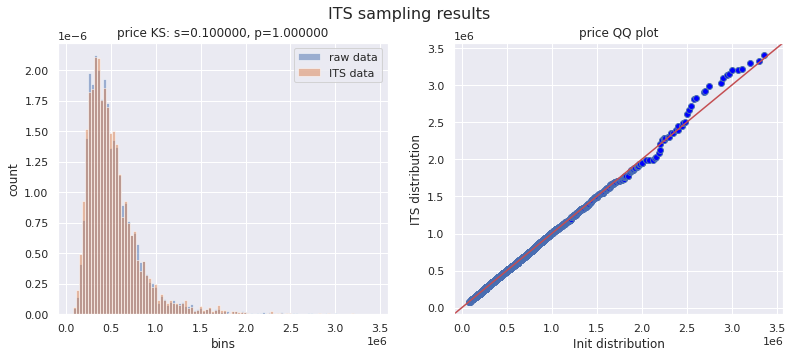

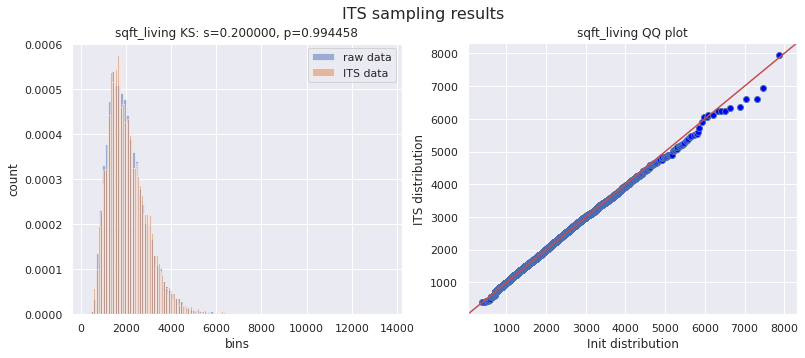

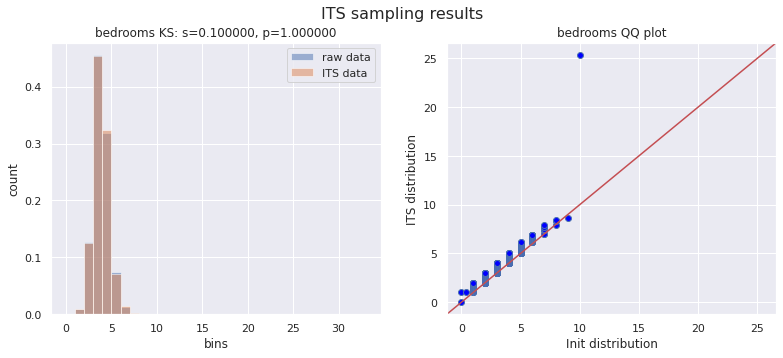

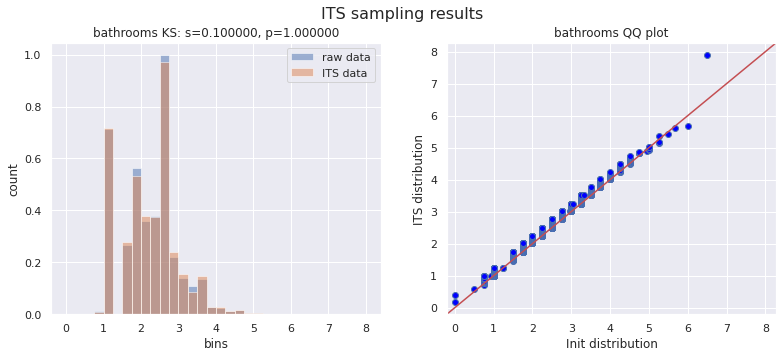

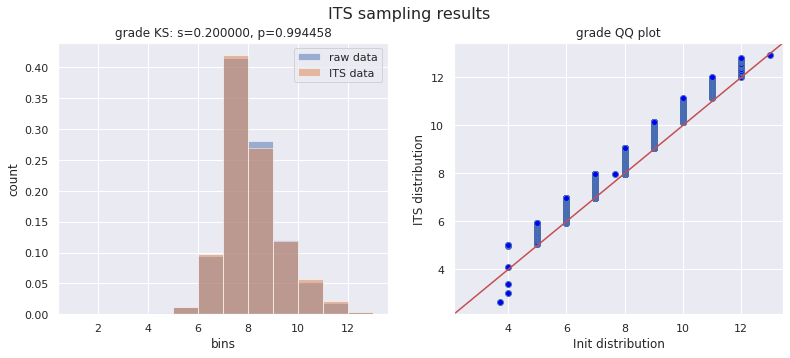

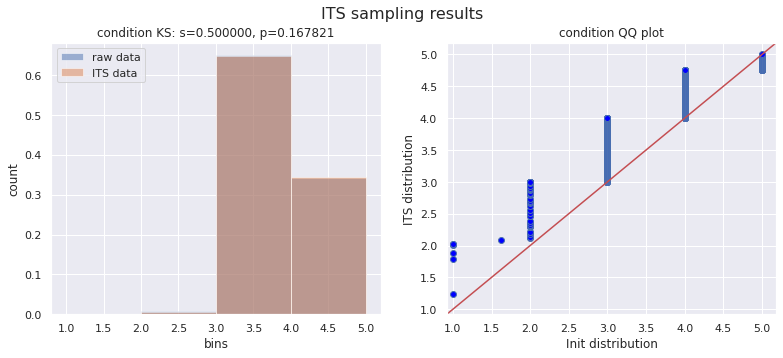

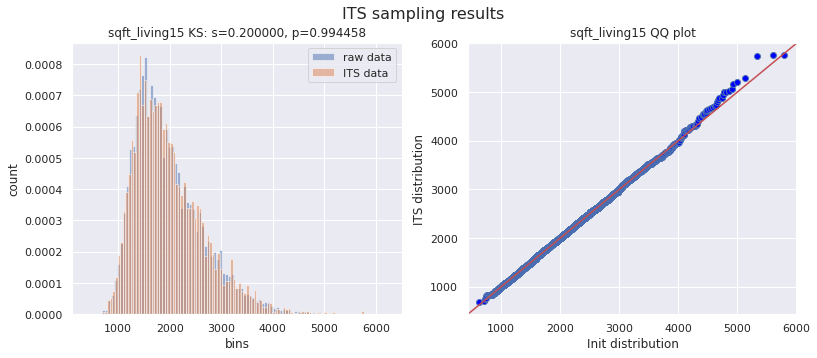

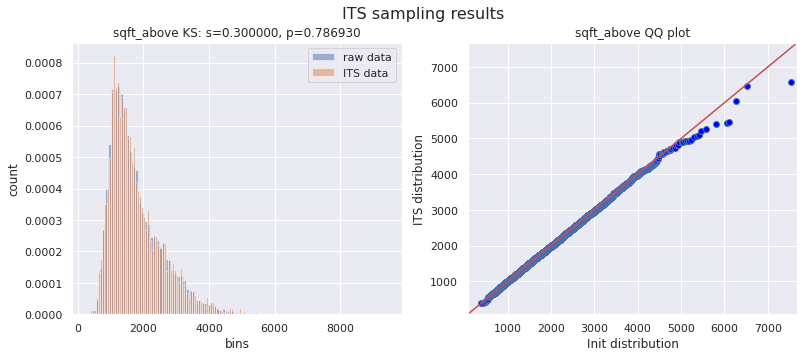

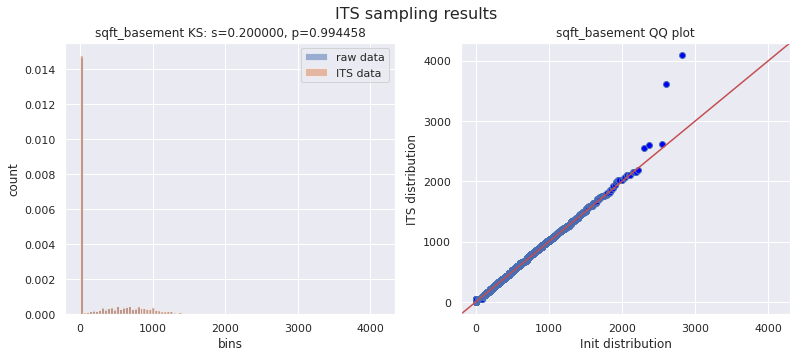

In [167]:
its_data = inverse_transform_sampling(data, n_buckets=100, n_samples=5000)
plot_stats_side2side(data, its_data, 'ITS')

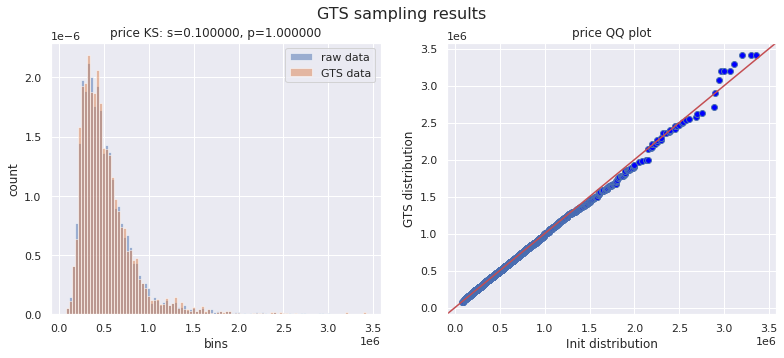

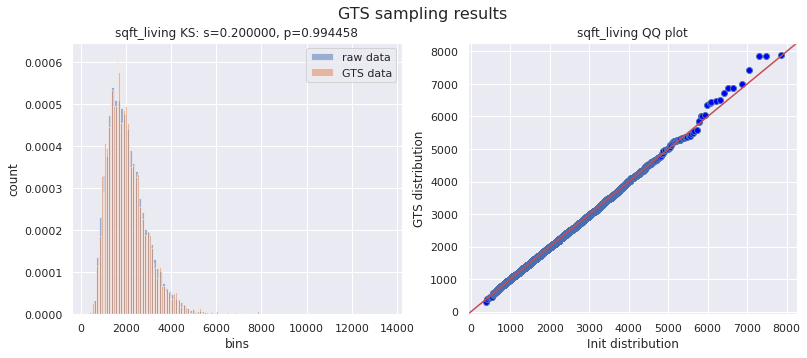

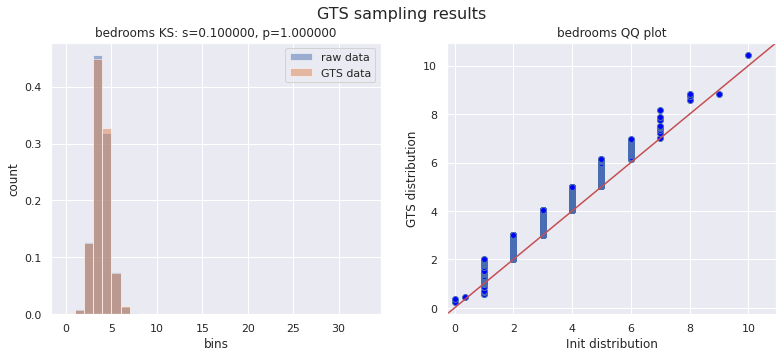

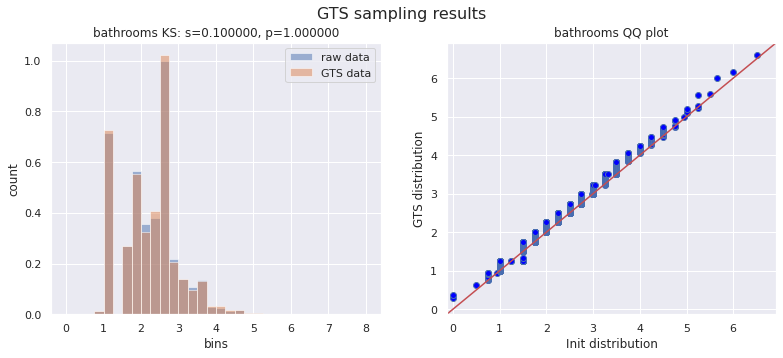

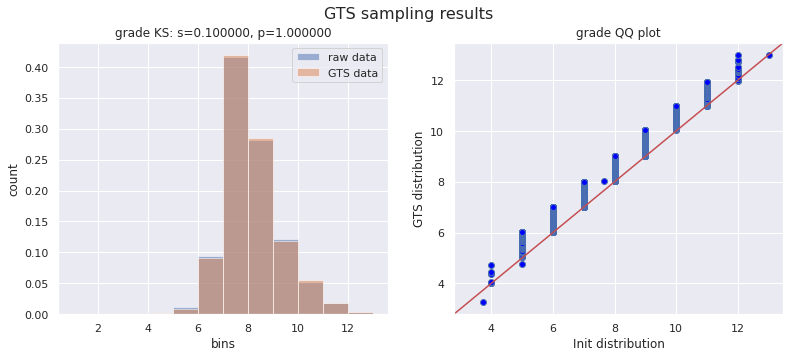

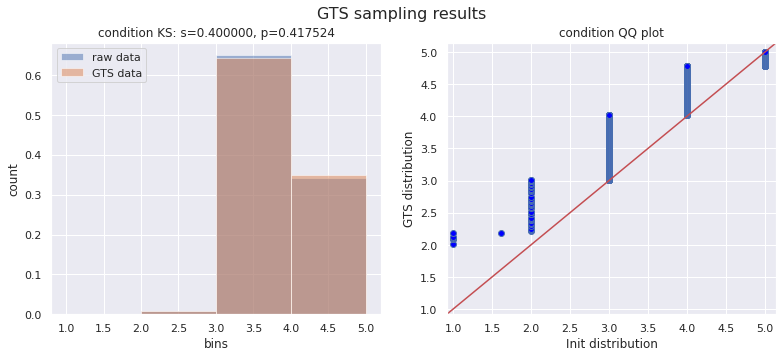

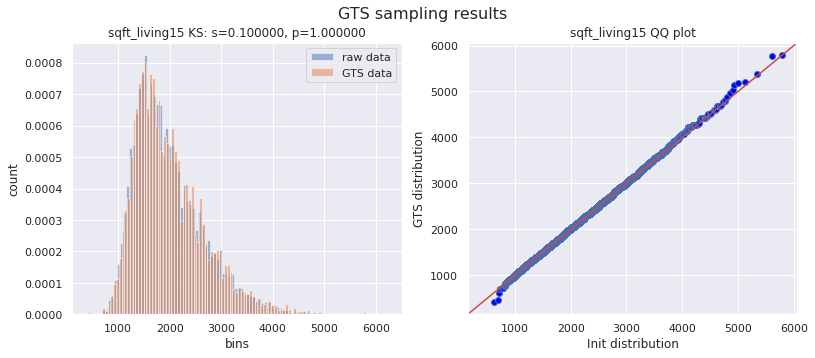

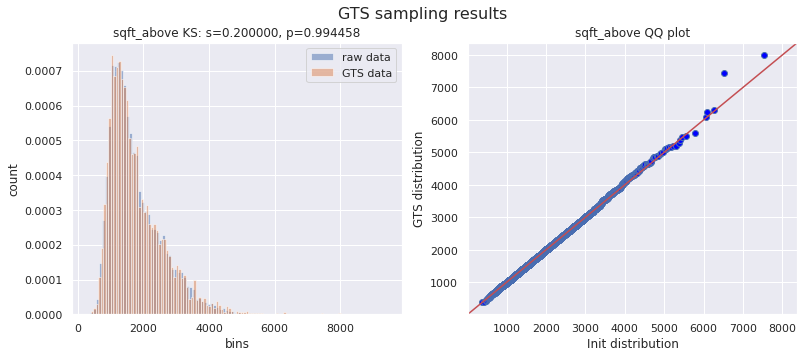

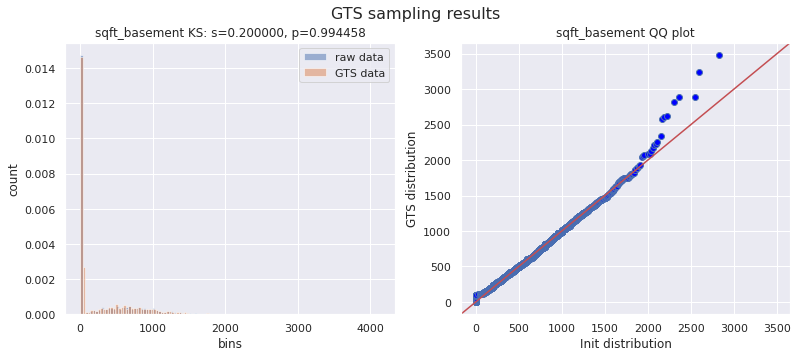

In [168]:
gts_data = geometric_transform_sampling(data, n_buckets=100, n_samples=5000)
plot_stats_side2side(data, gts_data, 'GTS')

# Correlation

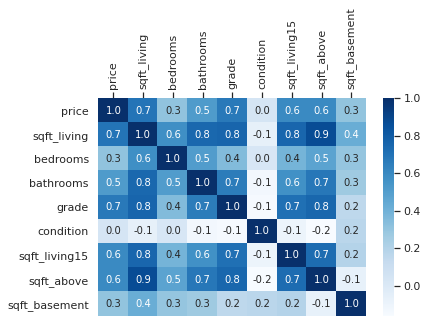

In [169]:
corr = data.corr()
sbr.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, fmt='.1f', cmap = 'Blues').xaxis.tick_top()
plt.xticks(rotation=90)
plt.show()

In [173]:
discretizer = preprocessing.KBinsDiscretizer(n_bins=100, encode='ordinal', strategy='uniform')

data_discrete = discretizer.fit_transform(data[predictors].values)
data_discrete = pd.DataFrame(data_discrete, columns=data[predictors].columns)

In [203]:
data_discrete.corr()

,price,sqft_living,sqft_living15,sqft_above,sqft_basement
price,1.000000,0.693098,0.598538,0.597822,0.312505
sqft_living,0.693098,1.000000,0.756483,0.873223,0.428553
sqft_living15,0.598538,0.756483,1.000000,0.730678,0.197311
sqft_above,0.597822,0.873223,0.730678,1.000000,-0.062993
sqft_basement,0.312505,0.428553,0.197311,-0.062993,1.000000


# Bayesian model

In [158]:
from pgmpy.estimators import HillClimbSearch, TreeSearch
from pgmpy.estimators import BDeuScore, K2Score, BicScore
from pgmpy.models import BayesianModel
from pgmpy.sampling import BayesianModelSampling
from pgmpy.inference import VariableElimination
from pgmpy.base import DAG

from collections import Counter

In [204]:
edges = {
    "price": ["sqft_living"],
    "sqft_living": ["sqft_living15", "sqft_above", "sqft_basement"],
}

edges_list = []
for out_var, in_vars in edges.items():
    for in_var in in_vars:
        edges_list.append((out_var, in_var))

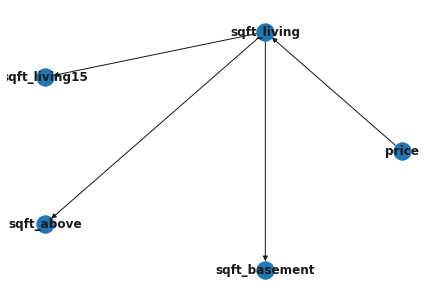

In [205]:
G_custom = nx.DiGraph(edges_list)
pos = nx.layout.circular_layout(G_custom)
nx.draw(G_custom, pos, with_labels=True,font_weight='bold')

bm_custom = BayesianModel(edges_list)

In [206]:
bm_custom.fit(data_discrete)

In [207]:
print(f"K2 score of hand-crafted model {K2Score(data_descrete).score(bm_custom):.2f}")
print(f"BIC score of hand-crafted model {BicScore(data_descrete).score(bm_custom):.2f}")

K2 score of hand-crafted model -110755.12
BIC score of hand-crafted model -110837.66


# Hill Search

hc = HillClimbSearch(df_disc, scoring_method=K2Score(df_disc))
best_model = hc.estimate()

In [196]:
hc = HillClimbSearch(data_discrete, scoring_method=K2Score(data_discrete)) 
bm_hill = hc.estimate()

  0%|          | 6/1000000 [00:06<288:31:53,  1.04s/it]


True


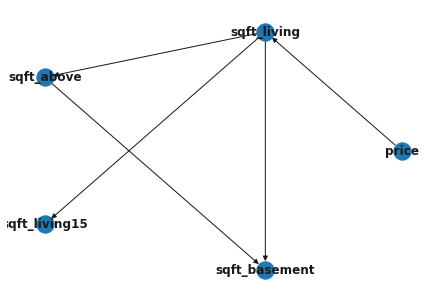

In [197]:
G_hill = nx.DiGraph()
G_hill.add_edges_from(bm_hill.edges())
pos = nx.layout.circular_layout(G_hill)
nx.draw(G_hill, pos, with_labels=True,font_weight='bold')
bm_hill = BayesianModel(bm_hill.edges())
bm_hill.fit(data_discrete)
print(bm_hill.check_model())

In [198]:
print(f"K2 score of tree model {K2Score(data_discrete).score(bm_hill):.2f}")
print(f"BIC score of tree model {BicScore(data_discrete).score(bm_hill):.2f}")

K2 score of tree model -295817.48
BIC score of tree model -1842733.42


# Tree Search

In [188]:
search = TreeSearch(data_discrete, root_node="price")
bm_tree = search.estimate()

Building tree: 100%|██████████| 10/10.0 [00:00<00:00, 4838.84it/s]


True


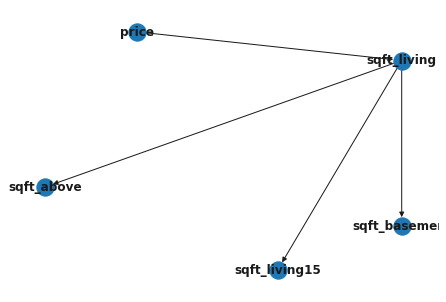

In [189]:
G_tree = nx.DiGraph()
G_tree.add_edges_from(bm_tree.edges())
nx.draw(G_tree, pos, with_labels=True,font_weight='bold')

bm_tree = BayesianModel(bm_tree.edges())
bm_tree.fit(data_descrete)
print(bm_tree.check_model())

In [180]:
print(f"K2 score of tree model {K2Score(data_descrete).score(bm_tree):.2f}")
print(f"BIC score of tree model {BicScore(data_descrete).score(bm_tree):.2f}")

K2 score of tree model -171026.69
BIC score of tree model -171164.64


# Evaluation

In [216]:
# define a function to train the Bayesian network model and plot the results

def train_and_plot(model, descritizer, data, keys, data_keys, title=''):

    def mean_absolute_percentage_error(y_true, y_pred): 
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
    def fit_model(model, data):
        new_model = BayesianModel(model.edges())
        
        new_model.fit(data)
        sampler = BayesianModelSampling(new_model)

        return sampler.forward_sample(len(data), return_type='dataframe')
    
    def get_scores(data, samples, title, key):
        y_true = np.sort(data)
        y_pred = np.sort(samples)

        corr_matrix = np.corrcoef(y_true, y_pred)
        corr = corr_matrix[0,1]
        R_sq = corr**2

        # print(f'R-2 score for {title} for {key} is: {R_sq}')
        # print(f'RMSE for {title} for {key} is: {np.sqrt(mean_squared_error(y_true, y_pred))}')
        # print(f'MAE for {title} for {key} is: {mean_absolute_error(y_true, y_pred)}')
        # print(f'MAPE for {title} for {key} is: {mean_absolute_percentage_error(y_true, y_pred)}')

        return R_sq, np.sqrt(mean_squared_error(y_true, y_pred)), mean_absolute_error(y_true, y_pred), mean_absolute_percentage_error(y_true, y_pred)
        
    sample_data = fit_model(model, data)

    data_continious = descritizer.inverse_transform(data_discrete.values)
    data_continious = pd.DataFrame(data_continious, columns=data_keys)
    sample_continious = descritizer.inverse_transform(sample_data.values)
    sample_continious = pd.DataFrame(sample_continious, columns=data_keys)

    # return sample_continious
    
    metrics = dict()
    
    for key in keys:

        real_data = data_descrete[key]
        sampled_data = sample_data[key]

        metr = get_scores(data_continious[key], sample_continious[key], title, key)
        metrics[key] = metr
        continue
        real_freqs = Counter(real_data)
        sampeled_freqs = Counter(sampled_data)

        a = min(min(real_freqs), min(sampeled_freqs))
        b = max(max(real_freqs), max(sampeled_freqs))
        x = np.arange(a, b + 1)

        plt.figure(figsize=(10, 5))
        plt.bar(x-0.3, [real_freqs[i] / len(real_data) for i in x], width=0.3, align='edge')
        plt.bar(x, [sampeled_freqs[i] / len(sampled_data) for i in x],  width=0.3, align='edge')

        plt.title(f'{title}')

        plt.ylabel('Probability')
        plt.legend([f'{key}', 'Generated data'])
        plt.show()
        
    return pd.DataFrame(metrics, index=['R2', 'RMSE', 'MAE', 'MAPE'])

In [217]:
custom_stats = train_and_plot(bm_custom, discretizer, data_discrete, data_discrete.columns, data_discrete.columns, 'Manual')

Generating for node: sqft_living:   0%|          | 0/5 [00:00<?, ?it/s]/home/rami/anaconda3/envs/ml/lib/python3.8/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:518: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  warn(
Generating for node: sqft_living15: 100%|██████████| 5/5 [00:01<00:00,  3.40it/s]


In [222]:
custom_stats

,price,sqft_living,sqft_living15,sqft_above,sqft_basement
R2,0.998894,0.997590,0.885612,0.999003,0.887353
RMSE,11511.689252,44.487683,1187.159149,26.310706,842.076577
MAE,2925.495901,6.885508,1163.761012,5.503849,825.860363
MAPE,0.407992,0.398037,62.198002,0.321709,2420.036155


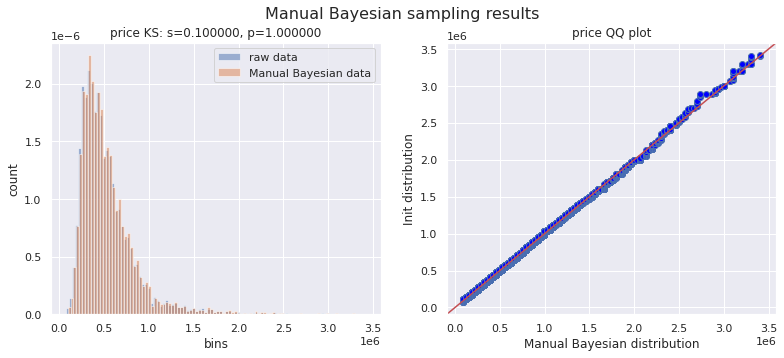

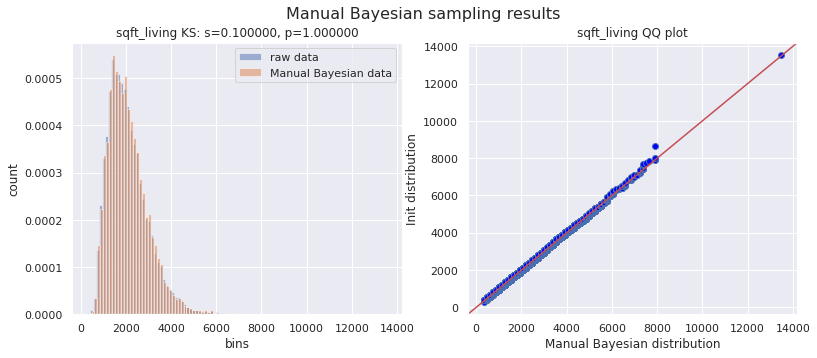

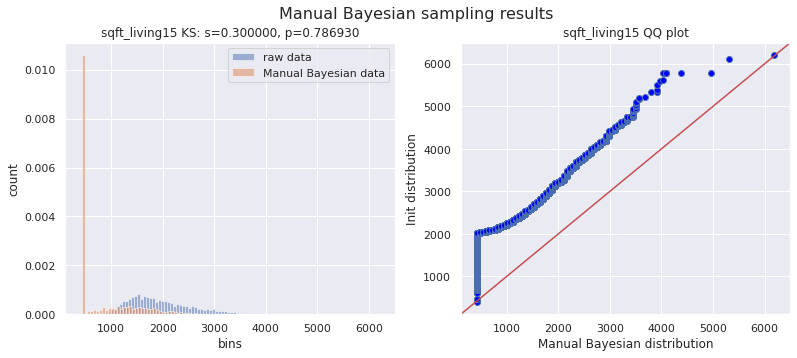

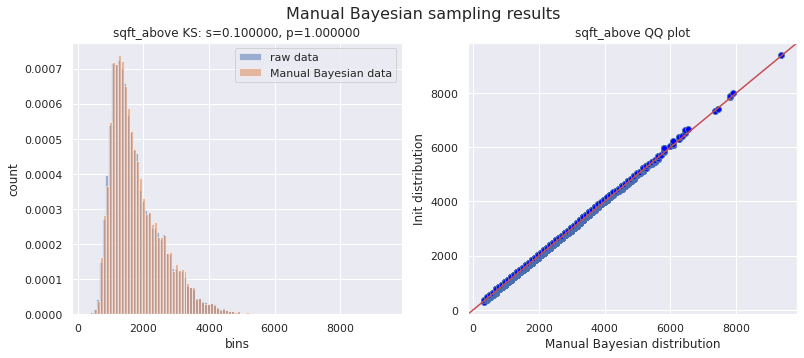

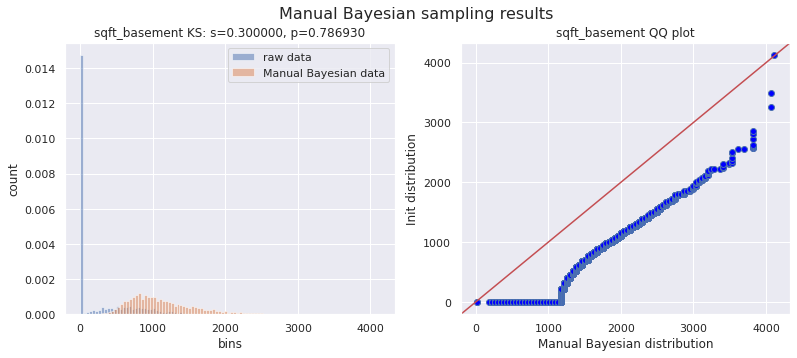

In [212]:
plot_stats_side2side(data, custom_stats, 'Manual Bayesian')

In [218]:
hill_stats = train_and_plot(bm_hill, discretizer, data_discrete, data_discrete.columns, data_discrete.columns, 'Hill Search')

Generating for node: sqft_living:   0%|          | 0/5 [00:00<?, ?it/s]/home/rami/anaconda3/envs/ml/lib/python3.8/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:518: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  warn(
Generating for node: sqft_basement: 100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


In [221]:
hill_stats

,price,sqft_living,sqft_living15,sqft_above,sqft_basement
R2,0.999152,0.997249,0.998880,0.998903,0.999217
RMSE,10295.864920,48.038086,23.652332,28.286337,12.206313
MAE,2163.535084,6.333194,9.131917,6.154342,2.689445
MAPE,0.345088,0.276145,0.454506,0.315565,1.399150


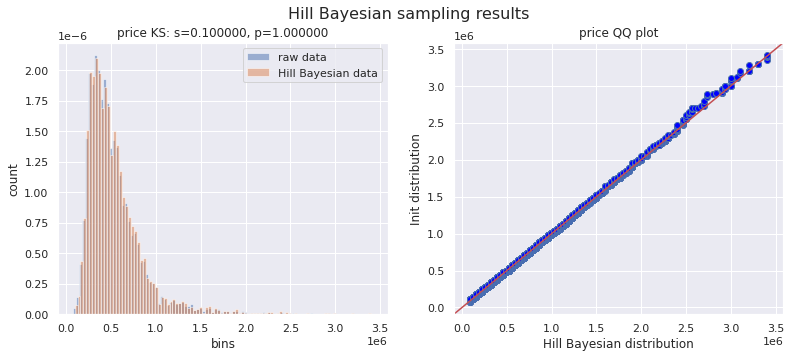

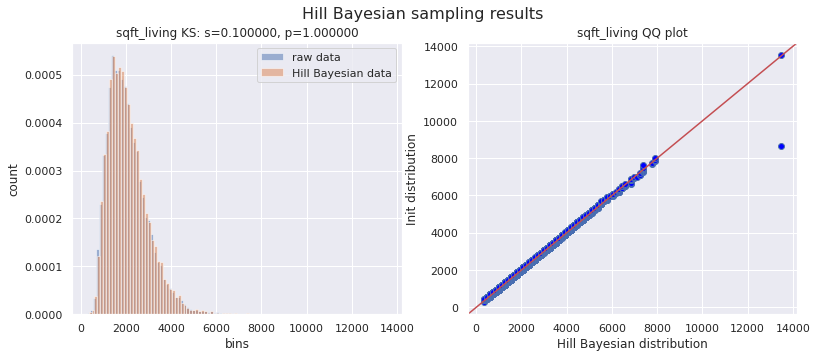

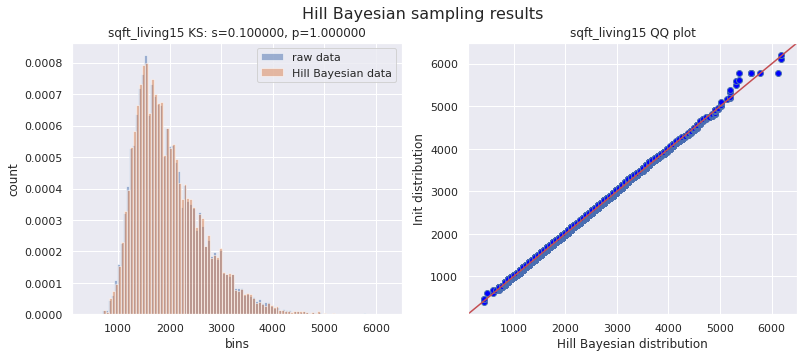

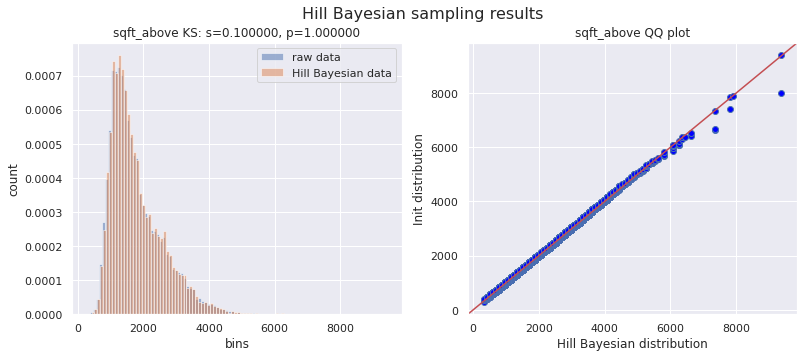

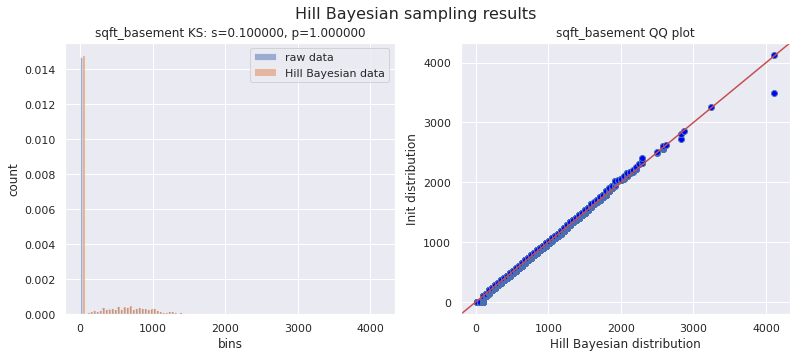

In [213]:
plot_stats_side2side(data, hill_stats, 'Hill Bayesian')

In [219]:
tree_stats = train_and_plot(bm_tree, discretizer, data_discrete, data_discrete.columns, data_discrete.columns, 'Tree search')

Generating for node: sqft_living:   0%|          | 0/5 [00:00<?, ?it/s]/home/rami/anaconda3/envs/ml/lib/python3.8/site-packages/pgmpy/factors/discrete/DiscreteFactor.py:518: UserWarning: Found unknown state name. Trying to switch to using all state names as state numbers
  warn(
Generating for node: sqft_above: 100%|██████████| 5/5 [00:01<00:00,  3.43it/s]   


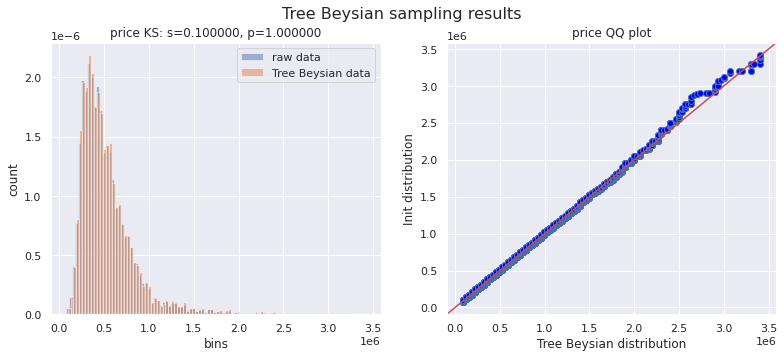

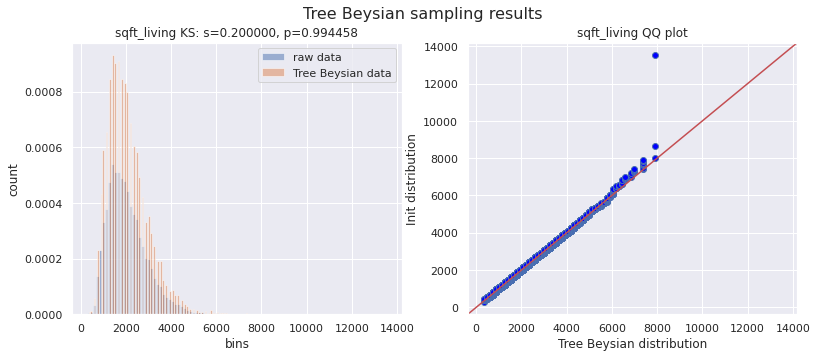

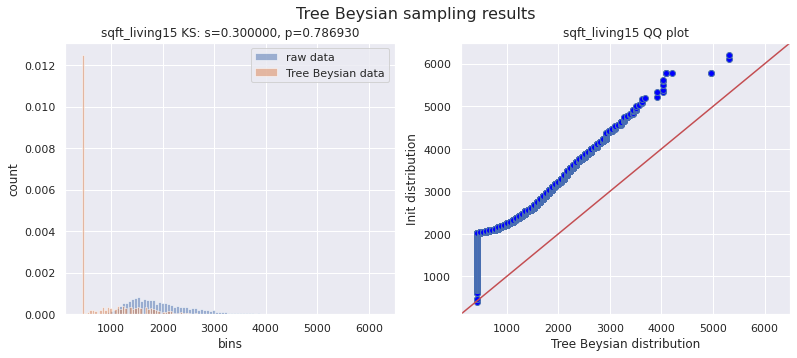

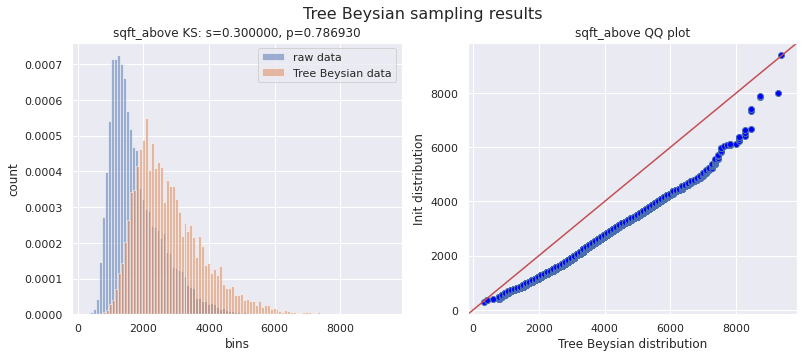

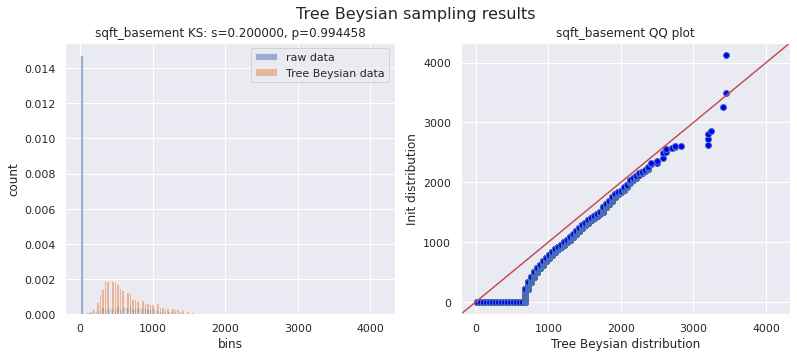

In [195]:
plot_stats_side2side(data, tree_stats, 'Tree Bayesian')

In [220]:
tree_stats

,price,sqft_living,sqft_living15,sqft_above,sqft_basement
R2,0.999453,0.999157,0.888091,0.993743,0.919302
RMSE,8493.358835,26.459466,1178.580817,1035.188177,395.823757
MAE,1729.898847,4.976958,1155.573775,999.744783,374.182859
MAPE,0.274047,0.234603,61.848724,60.103630,1264.284481
